Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

from model.modeloptimization import bij_transform, bij_transform_inv, calc_mse, calc_random_walk_loss, calc_prior_loss
from model.modelinitialisierung import initialize_observations, initialize_epsilon

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
from model.modelcore import epid_model

## Optimization Settings

In [3]:
start_time='2020-02-26'
end_time='2022-01-31'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cpu") #cuda:0

## Initialize Observations

In [4]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Admissions_hospital'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


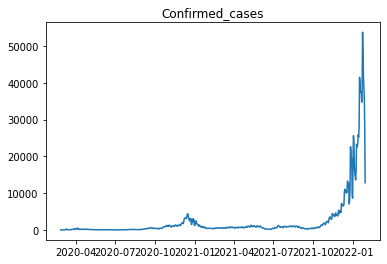

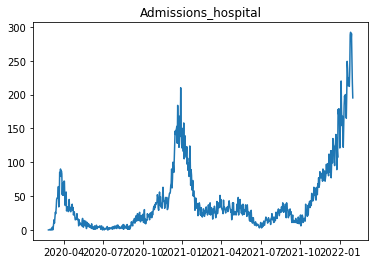

In [5]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [6]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [7]:
"""R0_lower, R0_upper = 2, 5
phi_lower, phi_upper = 0, 50
sigma_lower, sigma_upper = 0.00001, 0.5
alpha_lower, alpha_upper = 0.001, 0.05"""

'R0_lower, R0_upper = 2, 5\nphi_lower, phi_upper = 0, 50\nsigma_lower, sigma_upper = 0.00001, 0.5\nalpha_lower, alpha_upper = 0.001, 0.05'

In [8]:
"""R0_prime = bij_transform_inv(torch.tensor(3.6, device=device, dtype=dtype), R0_lower, R0_upper).detach().clone().requires_grad_(True)
phi_prime = bij_transform_inv(torch.tensor(25, device=device, dtype=dtype), phi_lower, phi_upper).detach().clone().requires_grad_(True)
sigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)
alpha_prime = bij_transform_inv(torch.tensor(0.01, device=device, dtype=dtype), alpha_lower, alpha_upper).detach().clone().requires_grad_(True)

sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)"""

'R0_prime = bij_transform_inv(torch.tensor(3.6, device=device, dtype=dtype), R0_lower, R0_upper).detach().clone().requires_grad_(True)\nphi_prime = bij_transform_inv(torch.tensor(25, device=device, dtype=dtype), phi_lower, phi_upper).detach().clone().requires_grad_(True)\nsigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)\nalpha_prime = bij_transform_inv(torch.tensor(0.01, device=device, dtype=dtype), alpha_lower, alpha_upper).detach().clone().requires_grad_(True)\n\nsigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)'

In [9]:
sigma_lower, sigma_upper = 0.00001, 0.5
sigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)
sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)
epsilon_t = initialize_epsilon(num_observations, sigma, device, dtype)

# Optimization

## Training

In [10]:
epochs = 10000
params = [epsilon_t]

optimizer = optim.Adam(params, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  optimizer.zero_grad()

  # forward pass
  expected = epsilon_t

  # calc loss
  loss = calc_mse(expected, observed)

  # backward pass
  loss.backward()
  optimizer.step()


# Evaluation

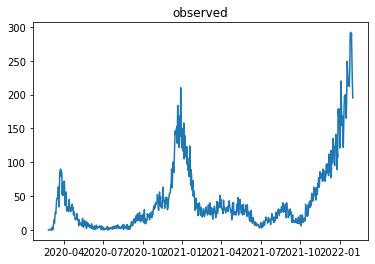

In [11]:
plt.plot(df_obs['Date'], observed.detach().numpy())
plt.title('observed')
plt.show()

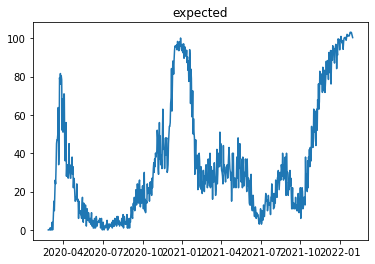

In [12]:
plt.plot(df_obs['Date'], epsilon_t.detach().numpy())
plt.title('expected')
plt.show()